In [1]:
import pip

def install(package):
   pip.main(['install', package])

install('torchvision') 

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Looking in indexes: https://mirrors.ustc.edu.cn/pypi/web/simple


In [2]:
import pandas as pd
import numpy as np
from IPython import display
import torch
import torch.nn as nn
import re
from sklearn.model_selection import train_test_split

In [3]:
# 读取数据
region = pd.read_csv('./data/附件1-区域15分钟负荷数据.csv')
industry = pd.read_csv('./data/附件2-行业日负荷数据.csv')
weather = pd.read_csv('./data/附件3-气象数据.csv')

## 观察数据

In [4]:
print(region.info())
print('====================================================================')
print(industry.info())
print('====================================================================')
print(weather.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128156 entries, 0 to 128155
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   数据时间       128156 non-null  object 
 1   总有功功率（kw）  128156 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.0+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3610 entries, 0 to 3609
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   行业类型         3610 non-null   object 
 1   数据时间         3610 non-null   object 
 2   有功功率最大值（kw）  3610 non-null   float64
 3   有功功率最小值（kw）  3610 non-null   float64
dtypes: float64(2), object(2)
memory usage: 112.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1345 entries, 0 to 1344
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   日期      1345 non-null   object
 1   天气状况    1345 non-null   object
 2

### 处理数据

In [5]:
region.columns = ['日期', '负荷']
industry.columns = ['行业类型', '日期', '负荷最大值', '负荷最小值']

In [6]:
# 转换为正确数据类型
region['日期'] = pd.to_datetime(region['日期'])
industry['日期'] = pd.to_datetime(industry['日期'])
weather['日期'] = pd.to_datetime(weather['日期'], format='%Y年%m月%d日')
# weather['日期'] = weather['日期'].apply(lambda x: re.sub(r"年|月", "-", x))
# weather['日期'] = weather['日期'].apply(lambda x: re.sub(r"日", "", x))
# weather['日期'] = pd.to_datetime(weather['日期'])

# 温度转换为整数
weather['最高温度'] = weather['最高温度'].apply(lambda x: x.replace('℃', '')).astype('int')
weather['最低温度'] = weather['最低温度'].apply(lambda x: x.replace('℃', '')).astype('int')

# 将日期拆分开来引入季节因素
date = weather['日期']
weather['日'] = date.apply(lambda x:x.day)
weather['月'] = date.apply(lambda x:x.month)
weather['年'] = date.apply(lambda x:x.year)

In [7]:
print(region.dtypes)
print('==================================')
print(region.dtypes, '\n')

日期    datetime64[ns]
负荷           float64
dtype: object
日期    datetime64[ns]
负荷           float64
dtype: object 



### 处理天气

#### 天气状况

In [8]:
# 天气状况分割为早上和晚上，并视为有序型数据进行处理
weather_condition = weather["天气状况"]
weather_condition_day = weather_condition.apply(lambda x:x.split("/")[0])
weather_condition_night = weather_condition.apply(lambda x:x.split("/")[1])
weather_condition_dict = { '晴':0,'晴间多云':0.5,'多云':1, '局部多云':1.5,'阴':2, '雾':2.5,
       '小雨':3, '小雨-中雨':3.5,'小到中雨':4,'中雨':4.5,'阵雨':5,'中雨-大雨':5.5,
       '中到大雨':6, '雷阵雨':6.5, '大雨':7, '大到暴雨':7.5, '暴雨':8, }
weather_condition_day = weather_condition_day.map(weather_condition_dict)
weather_condition_night = weather_condition_night.map(weather_condition_dict)
weather['白天天气状况'] = weather_condition_day
weather['夜晚天气状况'] = weather_condition_night

In [9]:
weather.head()

,日期,天气状况,最高温度,最低温度,白天风力风向,夜晚风力风向,日,月,年,白天天气状况,夜晚天气状况
0,2018-01-01,多云/多云,22,12,无持续风向<3级,无持续风向<3级,1,1,2018,1.0,1.0
1,2018-01-01,多云/多云,22,12,无持续风向<3级,无持续风向<3级,1,1,2018,1.0,1.0
2,2018-01-02,多云/多云,22,15,无持续风向<3级,无持续风向<3级,2,1,2018,1.0,1.0
3,2018-01-03,多云/阴,23,15,无持续风向<3级,无持续风向<3级,3,1,2018,1.0,2.0
4,2018-01-04,多云/小雨,21,16,无持续风向<3级,无持续风向<3级,4,1,2018,1.0,3.0


#### 风力风向

In [10]:
weather['夜晚风力风向'] = weather['夜晚风力风向'].apply(lambda x:x.replace("～","-"))
weather['白天风力风向'] = weather['白天风力风向'].apply(lambda x:x.replace("～","-"))

In [11]:
# 风向
# 分为有持续风向和无持续风向
def direct(x):
    dirct = re.match('.*(["东","南","西","北","东南","东北","西南","西北"])',x)
    if(dirct):
        return 2
    else :
        return 1

# 风力级别视为有序型数据进行处理
wind_power_dict = {"1-2级":1.5,'2':2,"3":3,"风":1,"3级":3,"3-4级":3.5, "4-5级":4.5,"8-9级":8.5}

# 夜晚
## 风向
weather['夜晚风力风向'].apply(lambda x:re.match("\D*(.+)级{0,}",x).group(1)).map(wind_power_dict)
direction = weather['夜晚风力风向'].apply(lambda x:direct(x)) + weather['白天风力风向'].apply(lambda x:direct(x)) # 计算当日风向和，有持续风向的+2，无持续风向的+1
weather['风向'] = direction

## 风力
weather['风力'] = weather['白天风力风向'].apply(lambda x:re.match("\D*(.+)级{0,}",x).group(1)).map(wind_power_dict) + \
    weather['夜晚风力风向'].apply(lambda x:re.match("\D*(.+)级{0,}",x).group(1)).map(wind_power_dict) # 计算当日风力和

In [12]:
weather

,日期,天气状况,最高温度,最低温度,白天风力风向,夜晚风力风向,日,月,年,白天天气状况,夜晚天气状况,风向,风力
0,2018-01-01,多云/多云,22,12,无持续风向<3级,无持续风向<3级,1,1,2018,1.0,1.0,2,6.0
1,2018-01-01,多云/多云,22,12,无持续风向<3级,无持续风向<3级,1,1,2018,1.0,1.0,2,6.0
2,2018-01-02,多云/多云,22,15,无持续风向<3级,无持续风向<3级,2,1,2018,1.0,1.0,2,6.0
3,2018-01-03,多云/阴,23,15,无持续风向<3级,无持续风向<3级,3,1,2018,1.0,2.0,2,6.0
4,2018-01-04,多云/小雨,21,16,无持续风向<3级,无持续风向<3级,4,1,2018,1.0,3.0,2,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1340,2021-08-27,雷阵雨/雷阵雨,35,26,北风1-2级,北风1-2级,27,8,2021,6.5,6.5,4,3.0
1341,2021-08-28,雷阵雨/多云,33,26,北风1-2级,北风1-2级,28,8,2021,6.5,1.0,4,3.0
1342,2021-08-29,雷阵雨/雷阵雨,32,25,北风1-2级,北风1-2级,29,8,2021,6.5,6.5,4,3.0
1343,2021-08-30,阵雨/阵雨,34,26,北风1-2级,北风1-2级,30,8,2021,5.0,5.0,4,3.0


## 问题1

In [13]:
# 连接天气和区域负荷表，并填充缺失值
region_weather = pd.merge(left=region, right=weather, how='outer', on='日期').drop_duplicates(subset=['日期'], ignore_index=True)
region_weather = region_weather[~region_weather['负荷'].isnull()]
region_weather = region_weather.fillna(method='ffill')
region_weather['最高温度'] = region_weather['最高温度'].astype('int')
region_weather['最低温度'] = region_weather['最低温度'].astype('int')
region_weather['日'] = region_weather['日'].astype('int')
region_weather['月'] = region_weather['月'].astype('int')
region_weather['年'] = region_weather['年'].astype('int')
region_weather.head()

,日期,负荷,天气状况,最高温度,最低温度,白天风力风向,夜晚风力风向,日,月,年,白天天气状况,夜晚天气状况,风向,风力
0,2018-01-01 00:00:00,244033.7682,多云/多云,22,12,无持续风向<3级,无持续风向<3级,1,1,2018,1.0,1.0,2.0,6.0
1,2018-01-01 00:15:00,232720.6402,多云/多云,22,12,无持续风向<3级,无持续风向<3级,1,1,2018,1.0,1.0,2.0,6.0
2,2018-01-01 00:30:00,231685.6891,多云/多云,22,12,无持续风向<3级,无持续风向<3级,1,1,2018,1.0,1.0,2.0,6.0
3,2018-01-01 00:45:00,227581.3317,多云/多云,22,12,无持续风向<3级,无持续风向<3级,1,1,2018,1.0,1.0,2.0,6.0
4,2018-01-01 01:00:00,233482.4269,多云/多云,22,12,无持续风向<3级,无持续风向<3级,1,1,2018,1.0,1.0,2.0,6.0


# 日周期

In [14]:
time = pd.Series(pd.date_range(start='00:00', end='23:45', freq='15min')).dt.strftime('%H:%M')

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(22,10))
for i in range(1, 6):
    plt.plot(time, region_weather.set_index(['日期'])[f'2018-01-0{i}']['负荷'], label=f'2018-01-0{i}')
plt.autoscale()
plt.xticks(rotation=70)
plt.legend()
plt.savefig('日周期')
plt.show()

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

<Figure size 2200x1000 with 1 Axes>

# 周周期

In [16]:
import pandas as pd
import numpy as np
import re

from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

[223401.06603750002, 244520.58846562504, 260548.67507812497, 262986.8022604167, 263652.613175, 263810.6818729167, 259740.15250520836]


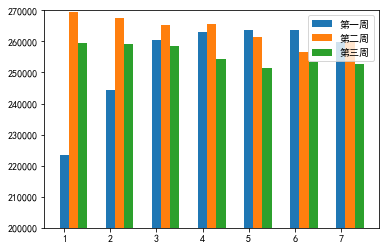

In [17]:

day = list(range(1, 8))
day = np.array(day)
height = []
for i in range(1, 8):
     height.append(region_weather.set_index(['日期'])[f'2018-01-{i}']['负荷'].mean())
    
print(height)
plt.bar(day, height,width=0.2, label='第一周')

height = []
for i in range(9, 16):
     height.append(region_weather.set_index(['日期'])[f'2018-01-{i}']['负荷'].mean())
plt.bar(day+0.2, height,width=0.2, label='第二周')

height = []
for i in range(17, 24):
     height.append(region_weather.set_index(['日期'])[f'2018-01-{i}']['负荷'].mean())
plt.bar(day+0.4, height,width=0.2, label='第三周')
plt.ylim(200000, 270000)
plt.legend()
plt.autoscale(axis='x', tight=None)
plt.savefig('周周期性')
plt.show()


In [18]:
for i in range(8, 15):
    height = region_weather.set_index(['日期'])[f'2018-01-{i}']['负荷'].mean()
height

256660.018265625

# 行业功率对比

In [19]:
industries = industry.groupby(['行业类型'])
types = industry['行业类型'].unique()
print(industries)

In [20]:
industry.drop(industry[industry['负荷最小值']<0].index, inplace=True)
industries

In [21]:
df = pd.DataFrame(columns=['负荷最小值', '负荷最大值'],index=types)
df['负荷最小值'] = industries.mean()['负荷最小值']
df['负荷最大值'] = industries.mean()['负荷最大值']
df

ValueError: len(index) != len(labels)

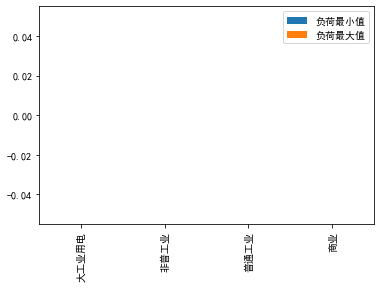

In [ ]:
df.plot.bar()
plt.savefig('行业对比')
plt.show()

In [ ]:
dt_range = pd.DataFrame(pd.date_range('2018-01-01 00:00:00', '2021-08-31 23:45:00', freq='15min'), columns=['日期'])
dt_range

,日期
0,2018-01-01 00:00:00
1,2018-01-01 00:15:00
2,2018-01-01 00:30:00
3,2018-01-01 00:45:00
4,2018-01-01 01:00:00
...,...
128539,2021-08-31 22:45:00
128540,2021-08-31 23:00:00
128541,2021-08-31 23:15:00
128542,2021-08-31 23:30:00


In [ ]:
merged_df = pd.merge(left=region_weather, right=dt_range, how='outer')
missing_date = merged_df[merged_df.isna()['负荷']]['日期']
missing_date

128156   2019-06-14 08:15:00
128157   2019-06-14 08:30:00
128158   2019-06-14 08:45:00
128159   2019-06-14 09:00:00
128160   2019-06-14 09:15:00
                 ...        
128539   2021-08-09 06:30:00
128540   2021-08-09 06:45:00
128541   2021-08-09 07:00:00
128542   2021-08-09 07:15:00
128543   2021-08-09 07:30:00
Name: 日期, Length: 388, dtype: datetime64[ns]

In [ ]:
pd.merge(left=region_weather, right=dt_range, how='outer').isna().sum()

日期          0
负荷        388
天气状况      388
最高温度      388
最低温度      388
白天风力风向    388
夜晚风力风向    388
日         388
月         388
年         388
白天天气状况    388
夜晚天气状况    388
风向        388
风力        388
dtype: int64

In [ ]:
dt_range

,日期
0,2018-01-01 00:00:00
1,2018-01-01 00:15:00
2,2018-01-01 00:30:00
3,2018-01-01 00:45:00
4,2018-01-01 01:00:00
...,...
128539,2021-08-31 22:45:00
128540,2021-08-31 23:00:00
128541,2021-08-31 23:15:00
128542,2021-08-31 23:30:00


### 模型训练

In [42]:
# 用前一天的数据预测后一天的数据
# 前一天的数据作为训练集，对后一天的负荷进行预测
region_weather_next_day = region_weather.shift(-96).dropna()['负荷']
X = region_weather.drop(columns=['负荷', '日期', '天气状况', '白天风力风向', '夜晚风力风向'])[:-96]
y = np.array(region_weather_next_day).reshape(-1, 1)

# 数据归一化
X_max, X_min, y_max, y_min = X.max(), X.min(), y.max(), y.min()
X = (X - X_min) / (X_max - X_min)
print(y[96*10:])
y = (y - y_min) / (y_max - y_min)

data = []
target = []
# for i in range(96*10, X.shape[0]):
    # data.append(X.iloc[i-96*10: i,:].values) 
    # print(data[0])
    # break
    # target.append(y[i])
target = y[96*10:]

data = np.array(data)
data = X[:-96*10]
target = np.array(target)


# 划分数据集
# X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, shuffle=False)
X_train, y_train = data.iloc[:-96*10], target[:-96*10]
X_test, y_test = data.iloc[-96*10:], target[-96*10:]
y_res = y * (y_max - y_min) + y_min

[[257279.1719]
 [244572.3949]
 [242882.9032]
 ...
 [200112.5091]
 [199865.5937]
 [198483.5592]]


In [44]:
pd.DataFrame(y_pred * (y_max - y_min) + y_min).to_csv('预测结果.csv')

,0
0,217814.6855
1,208631.8383
2,206770.4854
3,204902.7697
4,219528.8258
...,...
955,202409.1270
956,218576.4635
957,200112.5091
958,199865.5937


In [57]:
X = region_weather.drop(columns=['负荷', '日期', '天气状况', '白天风力风向', '夜晚风力风向'])
y = np.array(region_weather['负荷'])

In [60]:
X

,最高温度,最低温度,日,月,年,白天天气状况,夜晚天气状况,风向,风力
0,22,12,1,1,2018,1.0,1.0,2.0,6.0
1,22,12,1,1,2018,1.0,1.0,2.0,6.0
2,22,12,1,1,2018,1.0,1.0,2.0,6.0
3,22,12,1,1,2018,1.0,1.0,2.0,6.0
4,22,12,1,1,2018,1.0,1.0,2.0,6.0
...,...,...,...,...,...,...,...,...,...
128151,32,26,31,8,2021,6.5,5.0,4.0,3.0
128152,32,26,31,8,2021,6.5,5.0,4.0,3.0
128153,32,26,31,8,2021,6.5,5.0,4.0,3.0
128154,32,26,31,8,2021,6.5,5.0,4.0,3.0


In [62]:
len(y)

128156

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.99)

In [81]:
print(len(X_train))
print(len(X_test))

126874
1282


In [82]:
print(len(y_train))
print(len(y_test))

126874
1282


In [83]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
y_pred=model.fit(X_train,y_train)
r2_score( y_test,model.predict(X_test))

0.790334056116631

In [ ]:
test=

In [89]:
print(model.predict(X_test))

[207029.29767369 201012.85334372 194257.78582474 ... 253818.16729743
 232155.12450137 167336.13452004]


In [90]:
X_test

,最高温度,最低温度,日,月,年,白天天气状况,夜晚天气状况,风向,风力
54361,35,27,21,7,2019,6.5,1.0,2.0,3.0
45522,28,20,20,4,2019,4.5,6.5,2.0,3.0
29544,25,19,4,11,2018,3.0,2.0,2.0,3.0
80646,31,24,20,4,2020,1.0,1.0,2.0,3.0
43953,27,20,3,4,2019,2.0,5.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...
69,22,12,1,1,2018,1.0,1.0,2.0,6.0
66295,28,17,23,11,2019,0.0,0.0,2.0,3.0
2040,23,19,22,1,2018,2.0,2.0,2.0,6.0
95540,32,24,22,9,2020,6.5,6.5,4.0,3.0


<ipython-input-87-6c06b4197eb5>:3: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  plt.plot(y_test,c="r",label="y_test",color='red')
<ipython-input-87-6c06b4197eb5>:4: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  plt.plot(y_pred,c="b",label="y_pred",color="blue")


TypeError: float() argument must be a string or a number, not 'DecisionTreeRegressor'

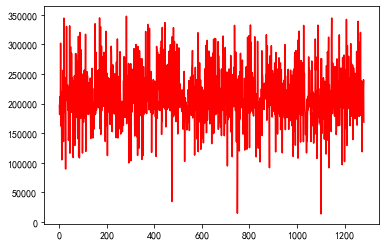

In [87]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(y_test,c="r",label="y_test",color='red')
plt.plot(y_pred,c="b",label="y_pred",color="blue")
plt.legend()

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
from IPython import display

In [ ]:
LR = 0.001
BATCH_SIZE = 96
TIME_STEP = 96 # rnn time step / image height
INPUT_SIZE = 9 # rnn input size / image width
EPOCH = 1

X_train = torch.from_numpy(X_train).to(torch.float32)
X_test = torch.from_numpy(X_test).to(torch.float32)
y_train = torch.from_numpy(y_train).to(torch.float32)
y_test = torch.from_numpy(y_test).to(torch.float32)

train_data = Data.TensorDataset(X_train, y_train)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [ ]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()

        self.lstm = nn.LSTM(
            input_size=INPUT_SIZE,
            hidden_size=64, # 隐藏层节点数
            num_layers=1, # LSTM隐藏层层数
            batch_first=True, # (batch, time_step, input)
        )

        self.out = nn.Linear(64, 1)

    def forward(self, X):
        # h_n, h_c是最后一个时刻的hidden state
        r_out, (h_n, h_c) = self.lstm(X, None) # 第一个hidden state没有
        # 因为结构是(batch, time_step, input)，所以-1选取最后一个时刻
        out = self.out(r_out[:, -1, :]) # 选取最后一个时刻的output
        return out

lstm = LSTM()
print(lstm)

In [ ]:
optimizer = torch.optim.Adam(lstm.parameters(), lr=LR)
loss_func = nn.MSELoss()

for epoch in range(EPOCH):
    for step, (X_batch, y_batch) in enumerate(train_loader):
        X_b = Variable(X_batch)
        y_b = Variable(y_batch)

        output = lstm(X_b)
        loss = loss_func(output, y_b)
        optimizer.zero_grad()
        loss.backward() # backpropagation
        optimizer.step()
        print(loss)

        if step % 50 == 0:
            test_output = lstm(X_test)
            y_pred = torch.max(test_output, 1)[1].data.squeeze()
            
            
            accuracy = (sum(y_pred == y_test) / y_test.size()[0]).item()
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.item(), '| test accuracy: ', accuracy)

# print 10 prediction2 from test data
torch_output = lstm(X_test[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(pred_y[:10], 'prediction number')
print(y_test[:10].numpy(), 'real number')

In [ ]:
y_test.squeeze()

In [ ]:
input_data = np.array(region_weather['负荷'])

In [ ]:
import matplotlib.pyplot as plt

def slidet(inputdata,step):
    inputdata = np.array(inputdata)
    n = inputdata.shape[0]
    t = np.zeros(n)
    n1 = step    #n1, n2为子序列长度，需调整
    n2 = step
    n11 = 1 / n1
    n22 = 1 / n2
    m = np.sqrt(n11 + n22)
    for i in range (step, n-step-1):
        x1_mean = np.mean(inputdata[i-step : i])   
        x2_mean = np.mean(inputdata[i : i+step])
        s1 = np.var(inputdata[i-step : i])          
        s2 = np.var(inputdata[i : i+step])
        s = np.sqrt((n1 * s1 + n2 * s2) / (n1 + n2 - 2))
        t[i] = (x2_mean - x1_mean) / (s * m)
    t[:step]=np.nan  
    t[n-step+1:]=np.nan             
    return  t

t = slidet(input_data, 96)

plt.figure(figsize=(10,5))
plt.plot(t,'r')
plt.axhline(1.8595)
plt.axhline(-1.8595)
plt.twinx()
plt.plot(input_data,'k')
plt.show()